# SQAE with DRC 

Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pennylane.optimize import AdamOptimizer
from models.quantum import qae

import warnings
warnings.filterwarnings('ignore')

2024-06-12 19:55:41.050798: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 19:55:41.050851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### settings

First fix some settings:

- INPUT_DATA_SIZE: The size the images will be scaled to (e.g. 12x12)  
- DRCs: The number of data reuploads in the encoder
- EPOCHS: number of epochs to train
- LATENT_QBITS: Number qbits in the latent space
- DATA_QBITS: number of qubits to use for the encoder

In [2]:
INPUT_DATA_SIZE = 12

DRCs = 2
EPOCHS = 4

LATENT_QBITS = 5
DATA_QBITS = 9

TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

### data 

We download MNIST as example images and normalize them

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

For a simple anomaly tagging setting, we filter out only threes and sixes.
We split them into seperate datasets.

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [5]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

Reshape for tf.image and scale down

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_train_threes = x_train_threes.reshape(x_train_threes.shape + (1,))
x_test_threes = x_test_threes.reshape(x_test_threes.shape + (1,))

In [7]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

2024-06-12 19:55:46.190378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:55:46.190658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 19:55:46.190735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-06-12 19:55:46.190795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-06-12 19:55:46.190854: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Two example images from the different classes

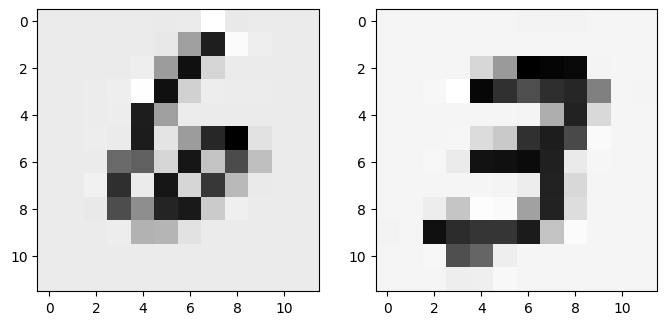

In [8]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].imshow(x_train_small[0], cmap='binary')
axs[1].imshow(x_train_3_small[0], cmap='binary')

drop last dimension as its (1,)

In [9]:
x_train_small = x_train_small.reshape(x_train_small.shape[:-1])
x_test_small = x_test_small.reshape(x_test_small.shape[:-1])

x_train_3_small = x_train_3_small.reshape(x_train_3_small.shape[:-1])
x_test_3_small = x_test_3_small.reshape(x_test_3_small.shape[:-1])

reduce the size of the data for faster training:

In [10]:
x_train_small = x_train_small[:4000]
x_train_3_small = x_train_3_small[:4000]
x_test_small = x_test_small[:900]
x_test_3_small = x_test_3_small[:900]

Now we have the following datasets:

In [11]:
print("x_train_small: ", x_train_small.shape)
print("x_test_small: ", x_test_small.shape)
print("x_train_3_small: ", x_train_3_small.shape)
print("x_test_3_small: ", x_test_3_small.shape)

x_train_small:  (4000, 12, 12)
x_test_small:  (900, 12, 12)
x_train_3_small:  (4000, 12, 12)
x_test_3_small:  (900, 12, 12)


## Circuit

Create pennylane device to simulate on. For cpu best fastest is lightning.qubit

In [12]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

Create SQAE model.
Since the input images are 12x12 we split it into 9 4x4 patches. Therfore we use 9 data qubits with kernel_size 4 and stride 4.
The fastest diff method for simulation is adjoint

In [13]:
# model = pQAE.ConvEncoderCircuit(DATA_QBITS,
#                       LATENT_QBITS, 
#                       dev1, 
#                       INPUT_DATA_SIZE, 
#                       kernel_size=4, 
#                       stride=4, 
#                       DRCs=DRCs, 
#                       diff_method="adjoint")

model = qae.QuantumAutoencoder(DATA_QBITS,
                      LATENT_QBITS, 
                      dev1, 
                      INPUT_DATA_SIZE, 
                      kernel_size=4, 
                      stride=4, 
                      DRCs=DRCs)


plot the circuit to check

2 circuit torch.Size([12, 12])
HERE
torch.Size([12, 12]) 4 4
0 4 0 4
imgae slide tensor([[0.3482, 0.8575, 0.8845, 0.9564],
        [0.0572, 0.9133, 0.5096, 0.1795],
        [0.5191, 0.0763, 0.4791, 0.3173],
        [0.6289, 0.7998, 0.1077, 0.0314]])
0
0 4 4 8
imgae slide tensor([[0.8842, 0.2694, 0.4877, 0.6878],
        [0.2795, 0.9363, 0.0863, 0.8740],
        [0.1482, 0.1940, 0.4395, 0.1259],
        [0.7669, 0.5002, 0.6577, 0.7234]])
1
0 4 8 12
imgae slide tensor([[0.1493, 0.0968, 0.6115, 0.0085],
        [0.2841, 0.1720, 0.8109, 0.5139],
        [0.3375, 0.0756, 0.3565, 0.0781],
        [0.5640, 0.8965, 0.8826, 0.4485]])
2
4 8 0 4
imgae slide tensor([[0.0741, 0.5917, 0.7023, 0.6047],
        [0.8109, 0.3620, 0.7328, 0.5701],
        [0.2605, 0.4690, 0.7564, 0.7590],
        [0.0549, 0.5827, 0.9914, 0.0650]])
3
4 8 4 8
imgae slide tensor([[0.5102, 0.5907, 0.7990, 0.7826],
        [0.5434, 0.5560, 0.0697, 0.9901],
        [0.9639, 0.7769, 0.9811, 0.8578],
        [0.9555, 0.5415, 0.9

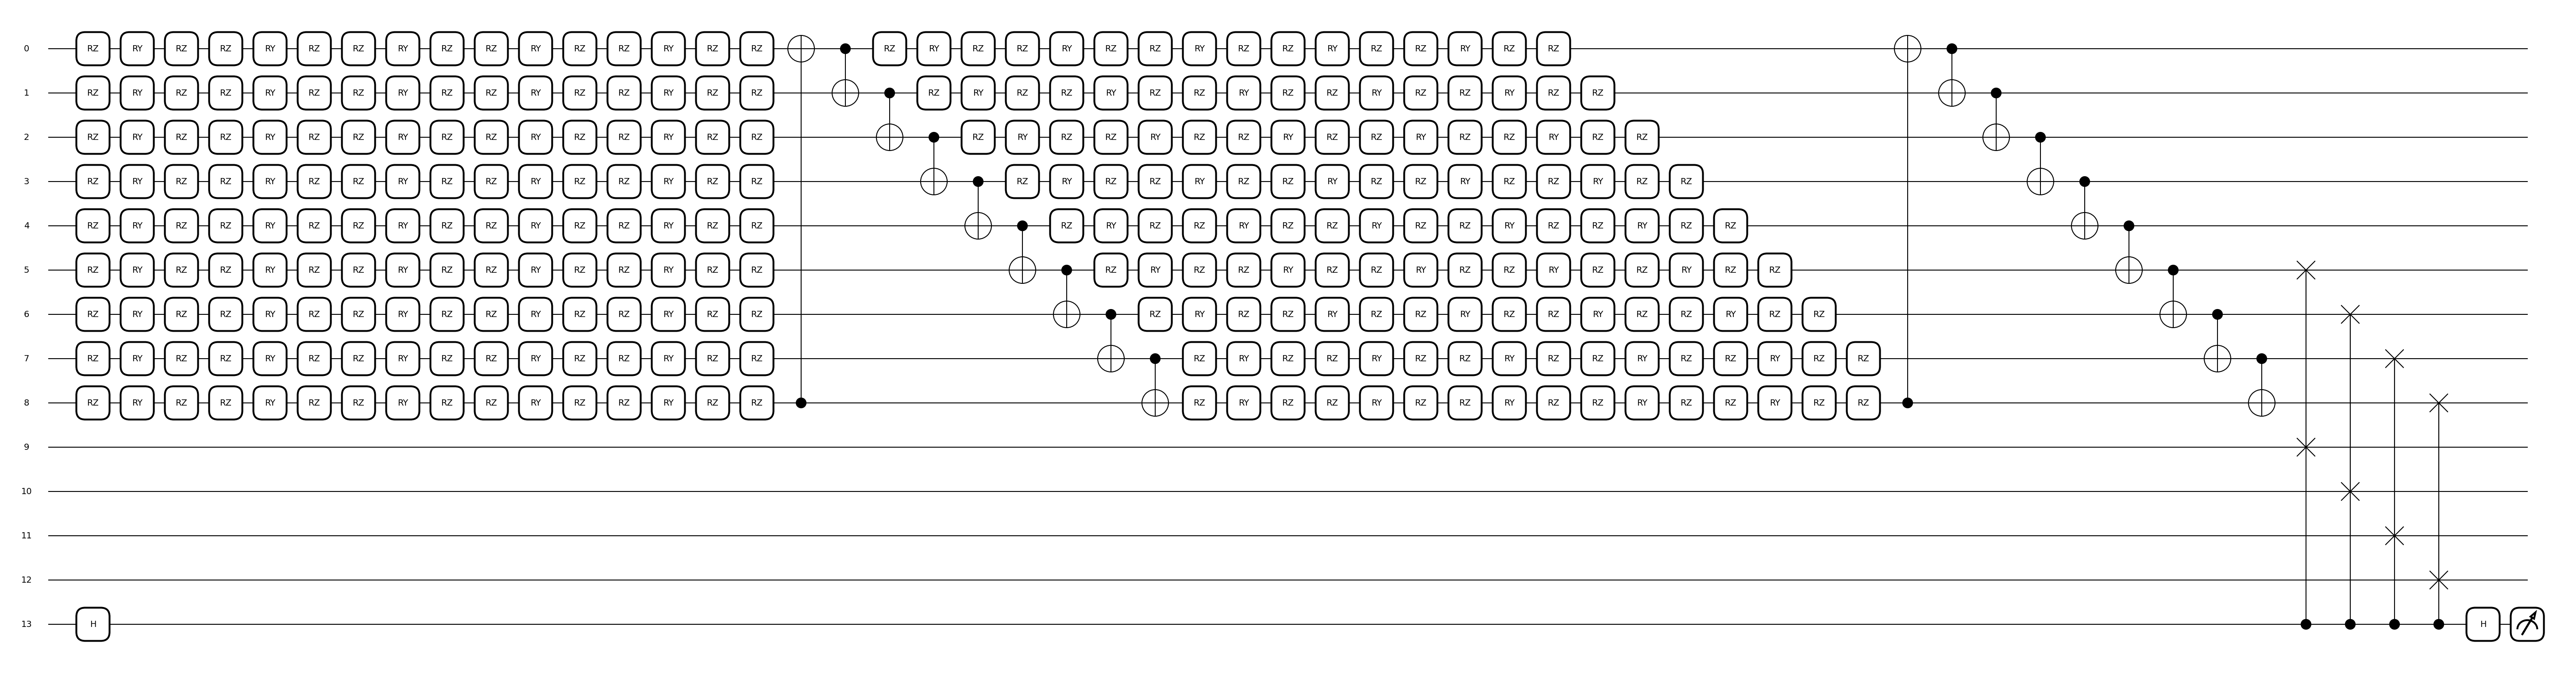

In [14]:
model.quantum_circuit.plot_circuit()

Train the model on the threes. Print step size gives the step interval to print loss and record the auc on tagging sixes with x_val_signa.

In [15]:
# model.train(x_train_3_small, x_test_3_small, 
#             learning_rate=0.01, 
#             epochs=EPOCHS, 
#             batch_size=30, 
#             print_step_size=100, 
#             save_auc=True,
#             x_val_signal=x_test_small)


from torch.utils.data import DataLoader, TensorDataset, random_split

train_loader = DataLoader(x_train_3_small, batch_size=32, shuffle=True)
val_loader = DataLoader(x_test_3_small, batch_size=32)

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

dev = qml.device('default.qubit', wires=8)
# model = ConvSQAE(data_qbits=8, latent_qbits=4, device=dev, img_dim=8, kernel_size=3, stride=1, DRCs=1, learning_rate=0.01)

logger = CSVLogger(save_dir="logs/", name="quantum_autoencoder")
trainer = pl.Trainer(max_epochs=3, logger=logger, gpus=0)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | quantum_layer | TorchLayer | 576   
---------------------------------------------
576       Trainable params
0         Non-trainable params
576       Total params
0.002     Total estimated model params size (MB)


Epoch 0:  31%|███       | 1523/4900 [00:06<00:13, 242.16it/s, loss=nan, v_num=44]